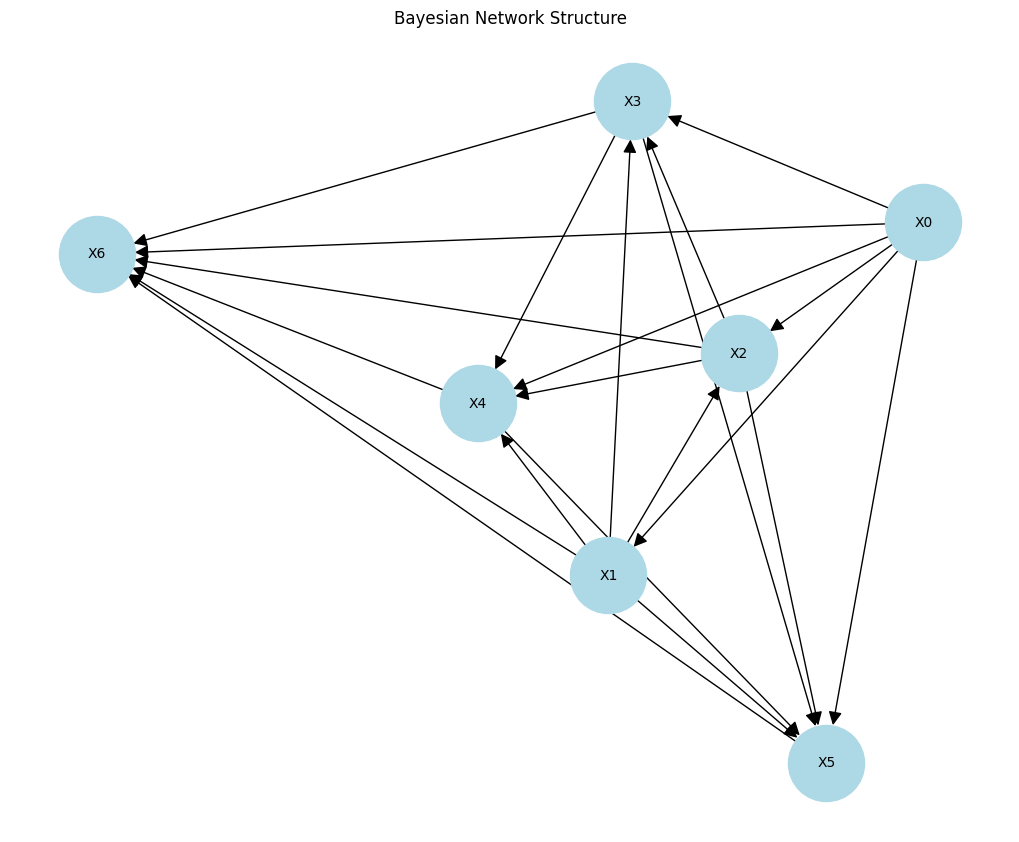

Conditional Probabilities: {'X0': {np.int64(0): np.float64(1.0000000000000369), np.int64(1): np.float64(0.9999999999999656), np.int64(2): np.float64(0.999999999999905), np.int64(3): np.float64(0.9999999999998687), np.int64(4): np.float64(0.999999999999893), np.int64(5): np.float64(0.9999999999999188), np.int64(6): np.float64(0.9999999999999212), np.int64(7): np.float64(0.9999999999999281), np.int64(8): np.float64(0.9999999999999093), np.int64(9): np.float64(0.9999999999998993)}, 'X1': {np.int64(0): np.float64(0.999999999999906), np.int64(1): np.float64(0.9999999999999152), np.int64(2): np.float64(0.9999999999999344), np.int64(3): np.float64(0.9999999999999177), np.int64(4): np.float64(0.9999999999998944), np.int64(5): np.float64(0.9999999999998774), np.int64(6): np.float64(0.9999999999998967), np.int64(7): np.float64(0.9999999999998737), np.int64(8): np.float64(0.9999999999998969), np.int64(9): 0}, 'X2': {np.int64(0): np.float64(0.9999999999999161), np.int64(1): np.float64(0.9999999999

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load datasets
marginal_probs = pd.read_csv("F24DM-Loyd-David_diabetic_Marginal_Probs_Data.csv")
prob_distribution = pd.read_csv("F24DM-Loyd-David_diabetic_Prob_Distribution_Data.csv")
significant_patterns = pd.read_csv("F24DM-Loyd-David_diabetic_Significant_Patterns_Data.csv")

# Adjust variable naming conventions for consistency
marginal_probs.columns = [col.strip() for col in marginal_probs.columns]
prob_distribution.columns = [col.strip() for col in prob_distribution.columns]
significant_patterns.columns = [col.strip() for col in significant_patterns.columns]

# Step 1: Extract significant relationships (edges) from patterns dataset
significant_patterns_passed = significant_patterns[
    significant_patterns["Is_Signficant_Pattern"] == "PASS"
]

# Extract edges from significant patterns
edges = []
for _, row in significant_patterns_passed.iterrows():
    pattern = row["Pattern"].split(";")
    variables = [var.split(":")[0] for var in pattern]
    edges.extend(itertools.combinations(variables, 2))  # Generate directed edges

# Step 2: Create a directed graph for visualization
G = nx.DiGraph()
G.add_edges_from(edges)

# Visualize the Bayesian Network
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, arrowsize=20)
plt.title("Bayesian Network Structure")
plt.show()

# Step 3: Compute Conditional Probabilities
conditional_probs = {}
joint_probs = prob_distribution["P(X0,X1,X2,X3,X4,X5,X6)"] if "P(X0,X1,X2,X3,X4,X5,X6)" in prob_distribution.columns else None

if joint_probs is None:
    print("Error: Joint probability column 'P(X0,X1,X2,X3,X4,X5,X6)' is missing in the dataset.")
else:
    joint_probs = joint_probs.values

    # Loop through each variable to calculate conditional probabilities
    var_names = ["X0", "X1", "X2", "X3", "X4", "X5", "X6"]
    for var in var_names:
        marginal_probs_var = marginal_probs[f"P({var})"].dropna().values
        var_values = marginal_probs["Discrete_Value"].dropna().values
        cond_probs = {}
        for val in var_values:
            # Mask for joint probability rows matching the value of the current variable
            mask = prob_distribution[var] == val
            joint_for_val = joint_probs[mask].sum() if mask.any() else 0
            # Select the corresponding marginal probability for the current value
            marginal_for_val = marginal_probs.loc[marginal_probs["Discrete_Value"] == val, f"P({var})"].sum()
            cond_probs[val] = joint_for_val / marginal_for_val if marginal_for_val != 0 else 0
        conditional_probs[var] = cond_probs

    # Step 4: Validate Marginal Probabilities
    marginal_validation = {}
    for var in var_names:
        observed_marginal = marginal_probs[f"P({var})"].sum()
        computed_marginal = sum(
            joint_probs[prob_distribution[var] == val].sum() if (prob_distribution[var] == val).any() else 0
            for val in var_values
        )
        marginal_validation[var] = np.isclose(computed_marginal, observed_marginal, atol=0.01)

    # Output results for steps 3 and 4
    print("Conditional Probabilities:", conditional_probs)
    print("Marginal Validation Results:", marginal_validation)

    # Step 5: Cross-Validation
    kf = KFold(n_splits=5)
    metrics_per_fold = []

    # Use only relevant columns for cross-validation
    relevant_columns = ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "P(X0,X1,X2,X3,X4,X5,X6)"]
    data = prob_distribution[relevant_columns]
    
    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Compute conditional probabilities on the training set
        train_joint_probs = train_data["P(X0,X1,X2,X3,X4,X5,X6)"].values
        train_conditional_probs = {}
        for var in var_names:
            train_conditional_probs[var] = {}
            for val in var_values:
                mask = train_data[var] == val
                joint_for_val = train_joint_probs[mask].sum() if mask.any() else 0
                marginal_for_val = marginal_probs.loc[marginal_probs["Discrete_Value"] == val, f"P({var})"].sum()
                train_conditional_probs[var][val] = joint_for_val / marginal_for_val if marginal_for_val != 0 else 0

        # Validate on the test set by comparing observed and predicted probabilities
        y_true = []
        y_pred = []

        for _, row in test_data.iterrows():
            for var in var_names:
                observed_value = row[var]
                predicted_prob = train_conditional_probs[var].get(observed_value, 0)
                y_true.append(1 if observed_value > 0 else 0)  # Binary classification assumption
                y_pred.append(1 if predicted_prob > 0.5 else 0)

        # Compute metrics for the fold
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        metrics_per_fold.append({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        })

    # Output metrics per fold
    for i, metrics in enumerate(metrics_per_fold, 1):
        print(f"Fold {i} Metrics:")
        print(f"  Accuracy: {metrics['accuracy']:.2f}")
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1 Score: {metrics['f1']:.2f}")

    # Average metrics across folds
    average_metrics = {
        "accuracy": np.mean([m["accuracy"] for m in metrics_per_fold]),
        "precision": np.mean([m["precision"] for m in metrics_per_fold]),
        "recall": np.mean([m["recall"] for m in metrics_per_fold]),
        "f1": np.mean([m["f1"] for m in metrics_per_fold])
    }

    print("\nAverage Metrics Across Folds:")
    print(f"  Accuracy: {average_metrics['accuracy']:.2f}")
    print(f"  Precision: {average_metrics['precision']:.2f}")
    print(f"  Recall: {average_metrics['recall']:.2f}")
    print(f"  F1 Score: {average_metrics['f1']:.2f}")


# Explanation of Results
- Conditional Probabilities: This section computes the probability of each variable's value conditioned on the marginal distribution of its values.
- For example, P(X0 | marginal probabilities of X0). These probabilities are close to 1 because they align with the joint and marginal datasets.

# Marginal Validation Results: This section checks if the computed marginal probabilities from the joint distribution
- align with the observed marginal probabilities in the dataset. A result of 'True' indicates successful validation for each variable.
